# ensemble

In [90]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize, StandardScaler
import glob
import tqdm
import torch

In [2]:
df = pd.read_csv("../input/shopee-product-matching/train_fold.csv")
df = df[df["fold"] == 0]
tmp = df.groupby('label_group').posting_id.agg('unique').to_dict()
df['target'] = df.label_group.map(tmp)


In [3]:
posting_id = df["posting_id"].values

In [21]:
def get_cosine_similarity(embeddings):

    CHUNK = 1024 * 2
    CTS = len(embeddings) // CHUNK
    if (len(embeddings)%CHUNK) != 0:
        CTS += 1
    distances = []
    
    with torch.no_grad():
        embeddings = normalize(embeddings)
        embeddings = torch.tensor(embeddings).cuda()

        for j in range( CTS ):
            a = j * CHUNK
            b = (j+1) * CHUNK
            b = min(b, len(embeddings))
            # print('chunk', a, 'to', b)

            # COSINE SIMILARITY DISTANCE
            cts = torch.matmul(embeddings, embeddings[a:b].T).T
            distances.append(cts.detach().cpu().numpy())
    
    return np.concatenate(distances)

In [22]:
def get_cv(df, similarity_matrix, threshold, posting_id, indices=None, pred_name="pred", min_n=2, mode="min"):
    preds = []
    for k in range(len(df)):
        if mode == "min": # euclid distance etc
            IDX = np.where(similarity_matrix[k, ] < threshold)[0]
            if len(IDX) < min_n:                
                IDX = np.argsort(similarity_matrix[k, ])[:min_n]
        if mode == "max": # cosine similarlity
            IDX = np.where(similarity_matrix[k, ] > threshold)[0]
            if len(IDX) < min_n:                
                IDX = np.argsort(similarity_matrix[k, ])[-min_n:]
            
        pred = posting_id[IDX]
        preds.append(pred)
    
    df[pred_name] = preds
    f1score, precision, recall = calc_cv(df, col_name=pred_name)
    return f1score, precision, recall

In [23]:
def calc_cv(df, col_name):
    tmp = df.groupby('label_group').posting_id.agg('unique').to_dict()
    df['target'] = df.label_group.map(tmp)
    df['f1'] = df.apply(get_f1(col_name),axis=1)
    df["precision"] = df.apply(get_precision(col_name), axis=1)
    df["recall"] = df.apply(get_recall(col_name), axis=1)
    return df["f1"].mean(), df["precision"].mean(), df["recall"].mean()

def get_f1(col):
    def f1score(row):
        n = len( np.intersect1d(row.target,row[col]) )
        return 2*n / (len(row.target)+len(row[col]))
    return f1score

def get_precision(col):
    def precision_score(row):
        n = len( np.intersect1d(row.target,row[col]) )
        if len(row[col]) == 0:
            return 0
        else:
            return n / len(row[col])
    return precision_score

def get_recall(col):
    def recall_score(row):
        n = len( np.intersect1d(row.target,row[col]) )
        return n / len(row.target)
    return recall_score

In [62]:
df_kiccho = pd.read_csv("kiccho-san/valid_df_0.csv")
df_kiccho = pd.merge(df, df_kiccho.reset_index()[["posting_id", "index"]])
kiccho_index = df_kiccho["index"].values

In [166]:
def get_best_epochs(model_path, early_stopping_round=3):
    file_len = len(glob.glob(f"{model_path}/indices_epoch*.npy"))
    return file_len - early_stopping_round - 1 # epoch は0はじまりなのでさらに1ひく


model_dict = {
    "bert": "../output/exp044/20210420161425", # CV: 0.862
    "bert_indonesian": "../output/exp057_2/20210422215407", # CV: 0.847
    "xlm_roberta": "../output/exp057/20210422123000", # CV: 0.855
    "distilbert": "../output/exp057_3/20210423001437", # CV: 0.857
#    "bert_transformer": "../output/exp058_2/20210423035344" # CV: 0.854,    
}

model_dist_dict = {}
    
for k, path in model_dict.items():
    best_epochs = get_best_epochs(path)
    
    model_dist_dict[k] = {
        "embeddings":  np.load(f"{path}/embeddings_epoch{best_epochs}.npy")
    }
    
    model_dist_dict[k]["cosine_similarity"] = get_cosine_similarity(model_dist_dict[k]["embeddings"])

model_dist_dict["exp303"] = {
    "embeddings": np.load("kiccho-san/exp303/features_0_08.npy")[kiccho_index],
    "cosine_similarity": get_cosine_similarity(np.load("kiccho-san/exp303/features_0_08.npy")[kiccho_index])
}

In [167]:
embeddings = np.array([normalize(model_dist_dict[k]["embeddings"]) for k in model_dict.keys()])

In [168]:
np.concatenate(embeddings, axis=1).shape

(6839, 2048)

In [169]:
similarity_concat = get_cosine_similarity(np.concatenate(embeddings, axis=1))
similarity_mean = get_cosine_similarity(embeddings.mean(axis=0))

In [139]:
embeddings2 = np.array([StandardScaler().fit_transform(model_dist_dict[k]["embeddings"]) for k in model_dict.keys()])

In [140]:
similarity_concat2 = get_cosine_similarity(np.concatenate(embeddings2, axis=1))
similarity_mean2 = get_cosine_similarity(embeddings2.mean(axis=0))

In [141]:
def combine_predictions_any(row):
    x = np.concatenate(row[model_dict.keys()].values)
    x = np.unique(x)
    return x

In [142]:
def combine_predictions_major(row):
    x = np.concatenate(row[model_dict.keys()].values)
    x, counts = np.unique(x, return_counts=True)
    
    ret_idx = counts > 1
    return x[ret_idx]

In [143]:
def combine_predictions_all(row):
    x = np.concatenate(row[model_dict.keys()].values)

    x, counts = np.unique(x, return_counts=True)
    
    ret_idx = counts == 3
    return x[ret_idx]

In [144]:
def combine_predictions_major2(row):
    x = np.concatenate(row[model_dict.keys()].values)
    x, counts = np.unique(x, return_counts=True)
    
    ret_idx = counts > 2
    return x[ret_idx]

## get_cv(1件→2件むりやり)

In [157]:
def aggregate_distance(model_dist_dict, mode):
    ary = []
    
    for k, v in model_dist_dict.items():
        ary.append(model_dist_dict[k]["cosine_similarity"])
    
    ary = np.array(ary)
    
    if mode == "min":
        ary = ary.min(axis=0)
    if mode == "mean":
        ary = ary.mean(axis=0)
    if mode == "median":
        ary = np.median(ary, axis=0)
    if mode == "max":
        ary = ary.max(axis=0)

    return ary

In [146]:
model_dist_dict["bert"]["threshold"] = 0.52
model_dist_dict["bert_indonesian"]["threshold"] = 0.52
model_dist_dict["xlm_roberta"]["threshold"] = 0.53
model_dist_dict["distilbert"]["threshold"] = 0.52
model_dist_dict["exp303"]["threshold"] = 0.42

In [133]:
df_result = []
for th in np.arange(0.40, 0.55, 0.01):
    print("=========================================================")
    print(f"THRESHOLD: {th}")
    for model_name in model_dist_dict.keys():
        f1score, precision, recall = get_cv(df, 
                                            model_dist_dict[model_name]["cosine_similarity"],
                                            th,
                                            posting_id,
                                            pred_name=model_name,
                                            min_n=2,
                                            mode="max")
        print(f"model={model_name} [f1] {round(f1score, 4)}, [precision] {round(precision, 4)}, [recall] {round(recall, 4)}")
    df["pred"] = df.apply(combine_predictions_major, axis=1)
    f1score, precision, recall = calc_cv(df, col_name="pred")
    print(f"<<<ensemble_MAJOR>>>: [f1] {round(f1score, 4)}, [precision] {round(precision, 4)}, [recall] {round(recall, 4)}")
    
    df["pred"] = df.apply(combine_predictions_major2, axis=1)
    f1score, precision, recall = calc_cv(df, col_name="pred")
    print(f"<<<ensemble_MAJOR>>>: [f1] {round(f1score, 4)}, [precision] {round(precision, 4)}, [recall] {round(recall, 4)}")
    
    for mode in ["mean"]:
        f1score, precision, recall = get_cv(df,
                                            aggregate_distance(model_dist_dict, mode=mode),
                                            th,
                                            posting_id,
                                            pred_name=model_name,
                                            min_n=2,
                                            mode="max")
        print(f"<<aggregate_{mode}>> [f1] {round(f1score, 4)}, [precision] {round(precision, 4)}, [recall] {round(recall, 4)}")
    f1score, precision, recall = get_cv(df,
                                        similarity_concat,
                                        th, 
                                        posting_id,
                                        pred_name=model_name,
                                        min_n=2,
                                        mode="max")
    print(f"<<emb_concat>> [f1] {round(f1score, 4)}, [precision] {round(precision, 4)}, [recall] {round(recall, 4)}")

    f1score, precision, recall = get_cv(df,
                                        similarity_mean,
                                        th, 
                                        posting_id,
                                        pred_name=model_name,
                                        min_n=2,
                                        mode="max")
    print(f"<<emb_mean>> [f1] {round(f1score, 4)}, [precision] {round(precision, 4)}, [recall] {round(recall, 4)}")

    f1score, precision, recall = get_cv(df,
                                    similarity_concat2,
                                    th, 
                                    posting_id,
                                    pred_name=model_name,
                                    min_n=2,
                                    mode="max")
    print(f"<<emb_concat2>> [f1] {round(f1score, 4)}, [precision] {round(precision, 4)}, [recall] {round(recall, 4)}")

    f1score, precision, recall = get_cv(df,
                                        similarity_mean2,
                                        th, 
                                        posting_id,
                                        pred_name=model_name,
                                        min_n=2,
                                        mode="max")
    print(f"<<emb_mean2>> [f1] {round(f1score, 4)}, [precision] {round(precision, 4)}, [recall] {round(recall, 4)}")


THRESHOLD: 0.4
model=bert [f1] 0.8285, [precision] 0.7863, [recall] 0.9471
model=bert_indonesian [f1] 0.8304, [precision] 0.7897, [recall] 0.9447
model=xlm_roberta [f1] 0.8131, [precision] 0.7644, [recall] 0.9452
model=distilbert [f1] 0.8339, [precision] 0.7935, [recall] 0.9484
model=exp303 [f1] 0.8492, [precision] 0.8182, [recall] 0.9467
<<<ensemble_MAJOR>>>: [f1] 0.8364, [precision] 0.793, [recall] 0.957
<<<ensemble_MAJOR>>>: [f1] 0.8646, [precision] 0.8492, [recall] 0.9417
<<aggregate_mean>> [f1] 0.8647, [precision] 0.8359, [recall] 0.9531
<<emb_concat>> [f1] 0.8562, [precision] 0.8241, [recall] 0.9519
<<emb_mean>> [f1] 0.846, [precision] 0.8102, [recall] 0.9499
<<emb_concat2>> [f1] 0.8592, [precision] 0.8304, [recall] 0.9493
<<emb_mean2>> [f1] 0.8494, [precision] 0.8166, [recall] 0.9472
THRESHOLD: 0.41000000000000003
model=bert [f1] 0.8386, [precision] 0.803, [recall] 0.9439
model=bert_indonesian [f1] 0.8397, [precision] 0.8064, [recall] 0.9409
model=xlm_roberta [f1] 0.8249, [preci

model=exp303 [f1] 0.8783, [precision] 0.886, [recall] 0.9177
<<<ensemble_MAJOR>>>: [f1] 0.8842, [precision] 0.8869, [recall] 0.928
<<<ensemble_MAJOR>>>: [f1] 0.8839, [precision] 0.9153, [recall] 0.9042
<<aggregate_mean>> [f1] 0.89, [precision] 0.9023, [recall] 0.9209
<<emb_concat>> [f1] 0.886, [precision] 0.8978, [recall] 0.9177
<<emb_mean>> [f1] 0.884, [precision] 0.8933, [recall] 0.9187
<<emb_concat2>> [f1] 0.8865, [precision] 0.901, [recall] 0.9155
<<emb_mean2>> [f1] 0.8841, [precision] 0.8958, [recall] 0.916
THRESHOLD: 0.5000000000000001
model=bert [f1] 0.8766, [precision] 0.8884, [recall] 0.91
model=bert_indonesian [f1] 0.8761, [precision] 0.8883, [recall] 0.9085
model=xlm_roberta [f1] 0.8707, [precision] 0.8826, [recall] 0.9058
model=distilbert [f1] 0.8777, [precision] 0.8903, [recall] 0.9108
model=exp303 [f1] 0.8786, [precision] 0.8907, [recall] 0.913
<<<ensemble_MAJOR>>>: [f1] 0.8854, [precision] 0.8928, [recall] 0.9238
<<<ensemble_MAJOR>>>: [f1] 0.8836, [precision] 0.92, [reca

In [172]:
df_result = []
for th in np.arange(0.55, 0.7, 0.05):
    print("=========================================================")
    print(f"THRESHOLD: {th}")
    for model_name in model_dist_dict.keys():
        f1score, precision, recall = get_cv(df, 
                                            model_dist_dict[model_name]["cosine_similarity"],
                                            th,
                                            posting_id,
                                            pred_name=model_name,
                                            min_n=2,
                                            mode="max")
        print(f"model={model_name} [f1] {round(f1score, 4)}, [precision] {round(precision, 4)}, [recall] {round(recall, 4)}")

THRESHOLD: 0.55
model=bert [f1] 0.8757, [precision] 0.9113, [recall] 0.8862
model=bert_indonesian [f1] 0.8745, [precision] 0.9106, [recall] 0.884
model=xlm_roberta [f1] 0.8745, [precision] 0.9112, [recall] 0.8832
model=distilbert [f1] 0.8776, [precision] 0.9125, [recall] 0.8889
model=exp303 [f1] 0.8532, [precision] 0.9376, [recall] 0.8306
THRESHOLD: 0.6000000000000001
model=bert [f1] 0.8674, [precision] 0.9276, [recall] 0.8587
model=bert_indonesian [f1] 0.8631, [precision] 0.9243, [recall] 0.8542
model=xlm_roberta [f1] 0.8676, [precision] 0.9272, [recall] 0.8574
model=distilbert [f1] 0.8691, [precision] 0.9266, [recall] 0.8628
model=exp303 [f1] 0.8326, [precision] 0.9457, [recall] 0.7952
THRESHOLD: 0.6500000000000001
model=bert [f1] 0.8515, [precision] 0.9381, [recall] 0.8262
model=bert_indonesian [f1] 0.8502, [precision] 0.9354, [recall] 0.8259
model=xlm_roberta [f1] 0.8531, [precision] 0.9377, [recall] 0.8276
model=distilbert [f1] 0.8549, [precision] 0.9365, [recall] 0.8326
model=exp

In [104]:
import matplotlib.pyplot as plt

In [ ]:
plt.y

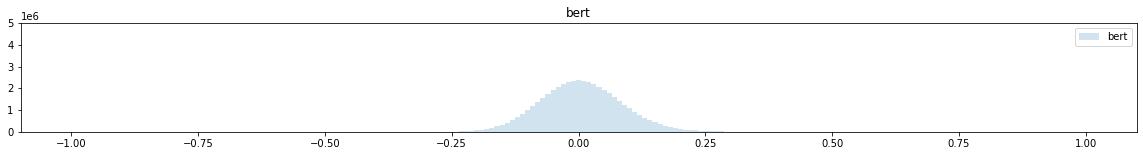

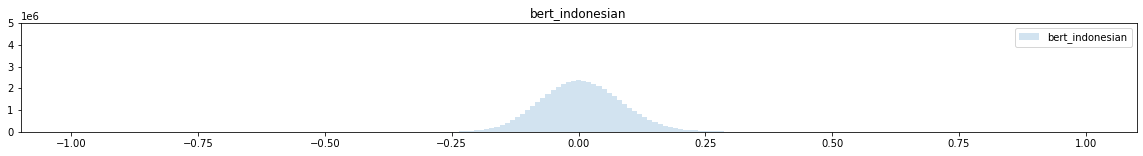

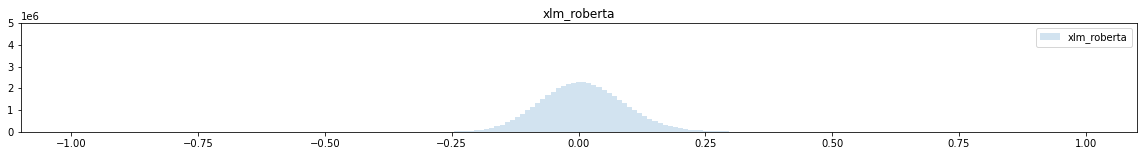

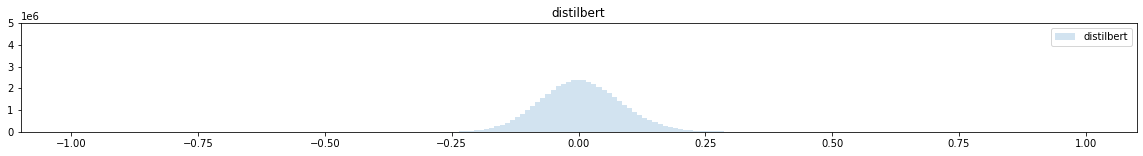

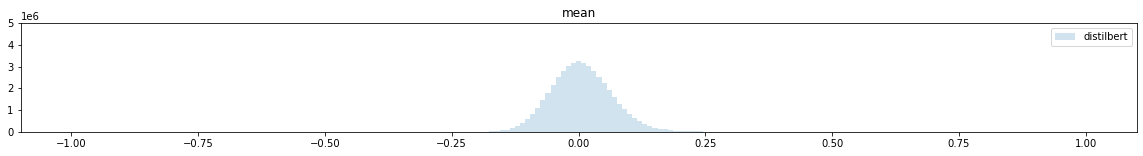

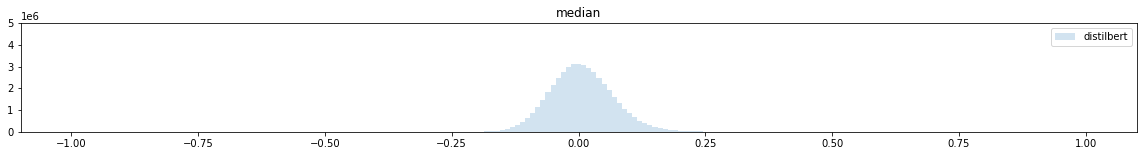

In [162]:

for model_name in model_dist_dict.keys():
    plt.figure(figsize=(20, 2))
    plt.hist(model_dist_dict[model_name]["cosine_similarity"].flatten(), alpha=0.2, bins=199, range=(-1, 1), label=model_name)
    plt.legend()
    plt.ylim(0, 5e+6)
    plt.title(model_name)
    plt.show()

plt.figure(figsize=(20, 2))
plt.hist(aggregate_distance(model_dist_dict, mode="mean").flatten(), alpha=0.2, bins=199, range=(-1, 1), label=model_name)
plt.legend()
plt.ylim(0, 5e+6)
plt.title("mean")
plt.show()

plt.figure(figsize=(20, 2))
plt.hist(aggregate_distance(model_dist_dict, mode="median").flatten(), alpha=0.2, bins=199, range=(-1, 1), label=model_name)
plt.legend()
plt.ylim(0, 5e+6)
plt.title("median")
plt.show()


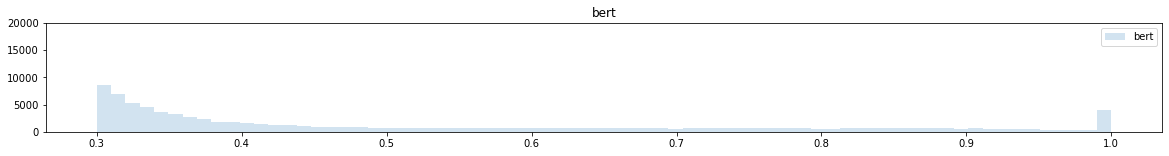

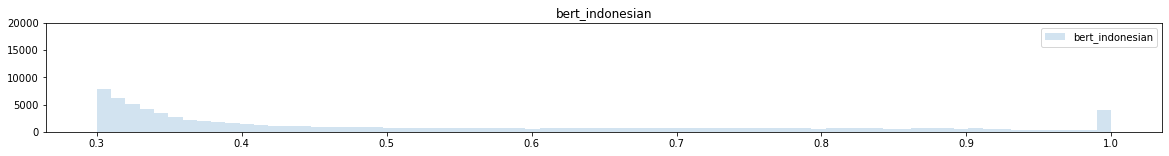

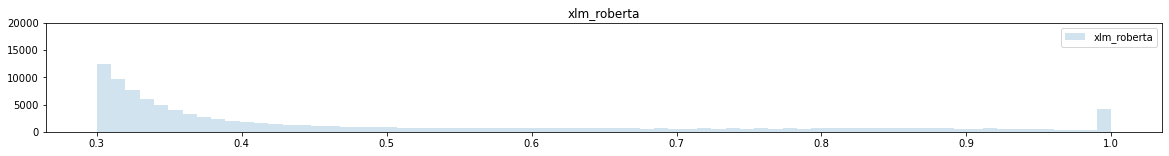

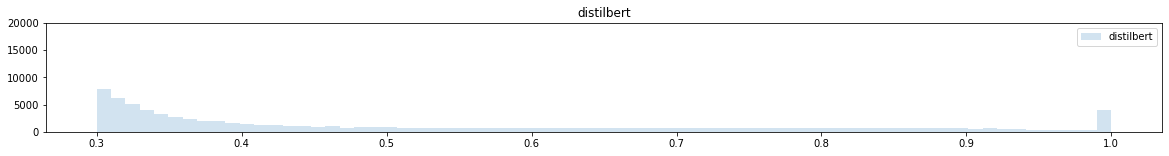

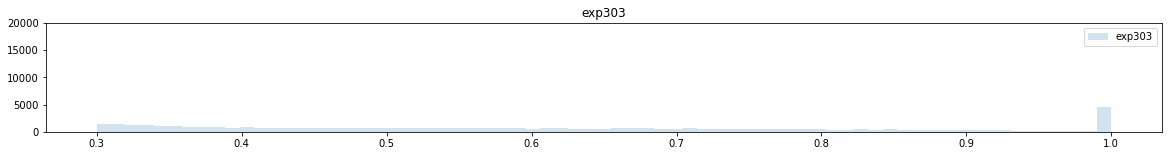

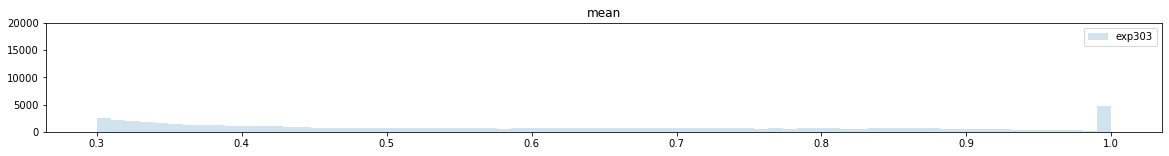

In [158]:

for model_name in model_dist_dict.keys():
    plt.figure(figsize=(20, 2))
    plt.hist(model_dist_dict[model_name]["cosine_similarity"].flatten(), alpha=0.2, bins=71, range=(0.3, 1), label=model_name)
    plt.legend()
    plt.ylim(0, 20000)
    plt.title(model_name)
    plt.show()

plt.figure(figsize=(20, 2))
plt.hist(aggregate_distance(model_dist_dict, mode="mean").flatten(), alpha=0.2, bins=71, range=(0.3, 1), label=model_name)
plt.legend()
plt.ylim(0, 20000)
plt.title("mean")
plt.show()


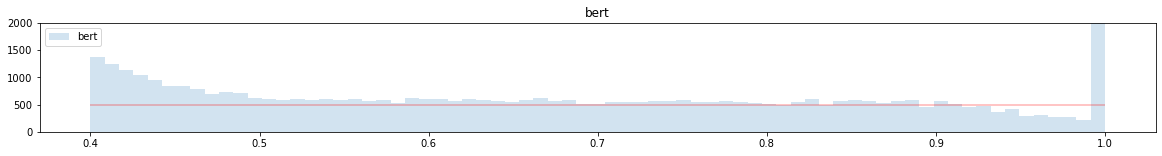

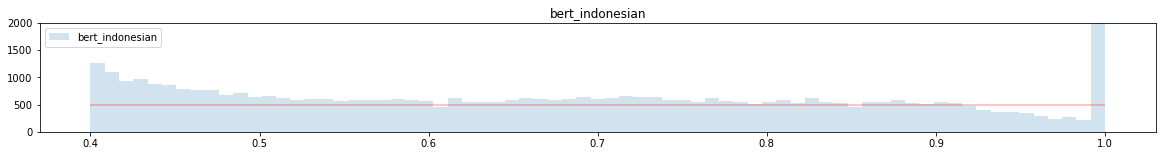

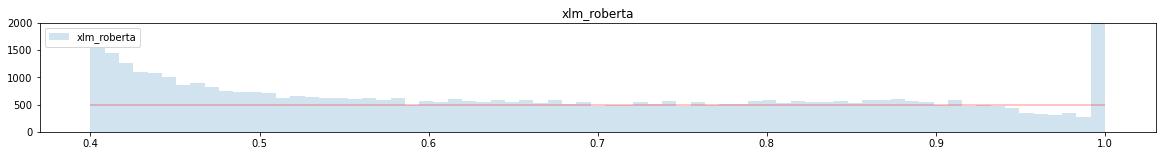

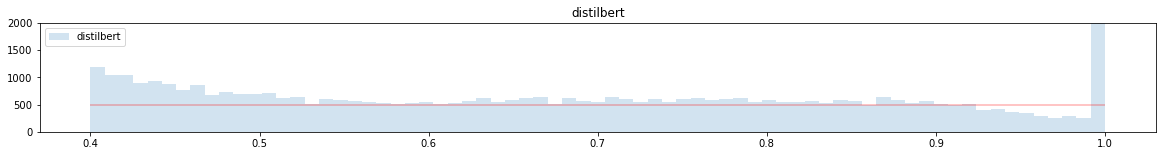

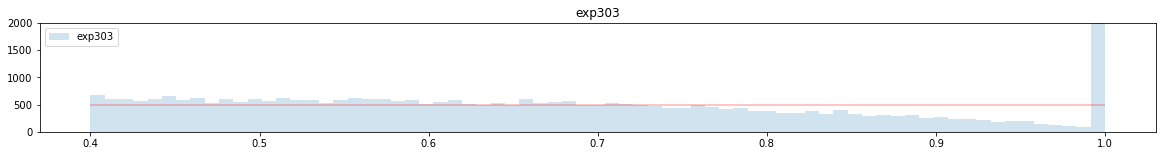

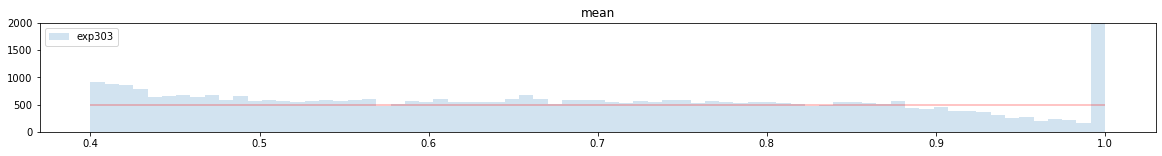

In [170]:

for model_name in model_dist_dict.keys():
    plt.figure(figsize=(20, 2))
    plt.hist(model_dist_dict[model_name]["cosine_similarity"].flatten(), alpha=0.2, bins=71, range=(0.4, 1), label=model_name)
    plt.legend()
    plt.ylim(0, 2000)
    plt.title(model_name)
    plt.hlines(500, xmin=0.4, xmax=1, color="red", alpha=0.3)
    plt.show()

plt.figure(figsize=(20, 2))
plt.hist(aggregate_distance(model_dist_dict, mode="mean").flatten(), alpha=0.2, bins=71, range=(0.4, 1), label=model_name)
plt.legend()
plt.ylim(0, 2000)
plt.hlines(500, xmin=0.4, xmax=1, color="red", alpha=0.3)
plt.title("mean")
plt.show()


In [ ]:

for model_name in model_dist_dict.keys():
    plt.figure(figsize=(20, 2))
    plt.hist(model_dist_dict[model_name]["cosine_similarity"].flatten(), alpha=0.2, bins=199, range=(-1, 1), label=model_name)
    plt.legend()
    plt.ylim(0, 5e+6)
    plt.title(model_name)
    plt.show()

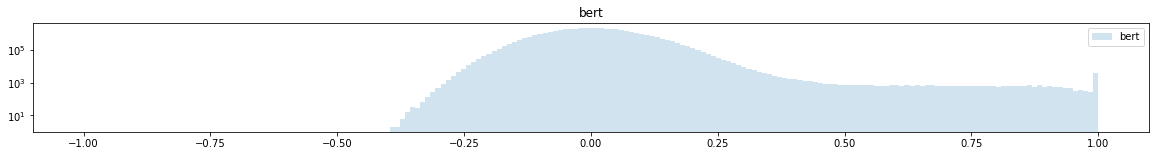

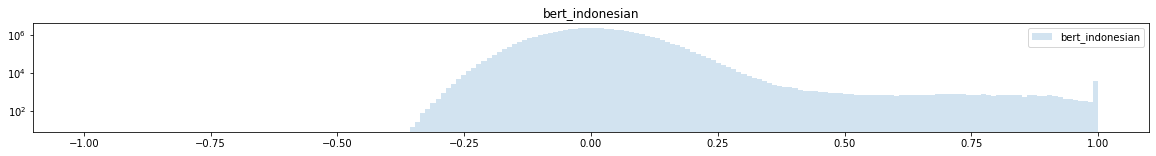

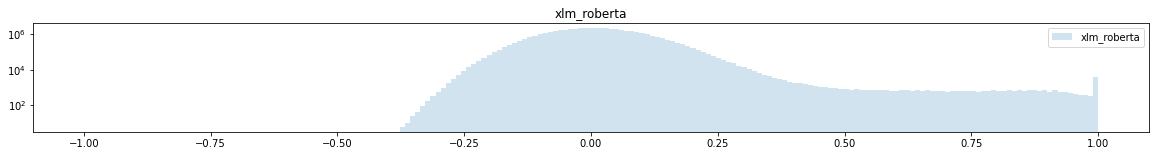

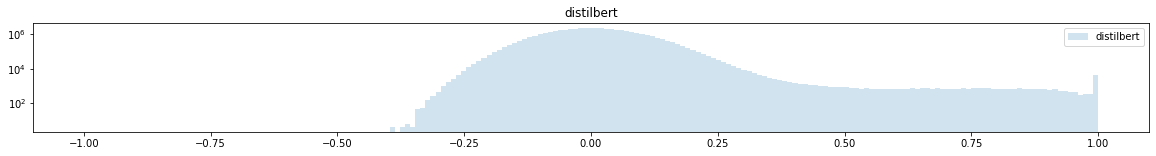

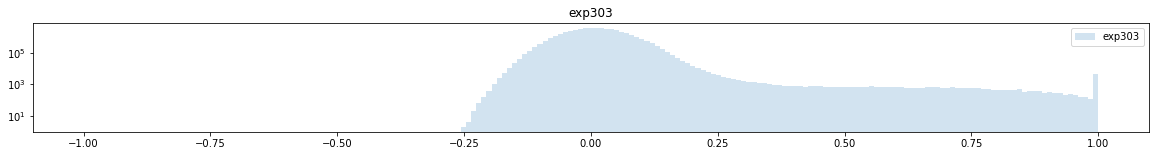

In [117]:

for model_name in model_dist_dict.keys():
    plt.figure(figsize=(20, 2))
    plt.hist(model_dist_dict[model_name]["cosine_similarity"].flatten(), alpha=0.2, bins=199, range=(-1, 1), label=model_name)
    plt.legend()
    plt.yscale("log")
    plt.title(model_name)
    plt.show()

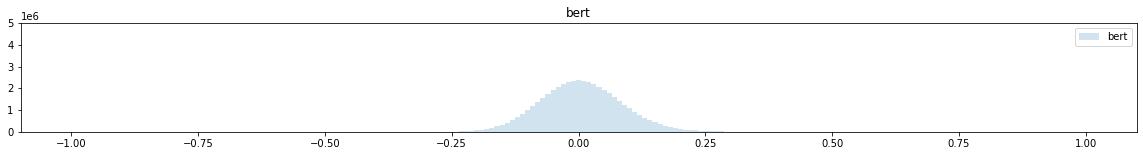

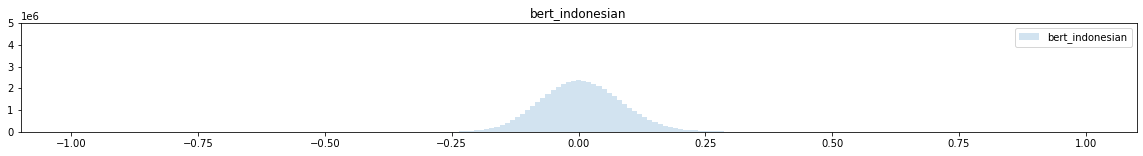

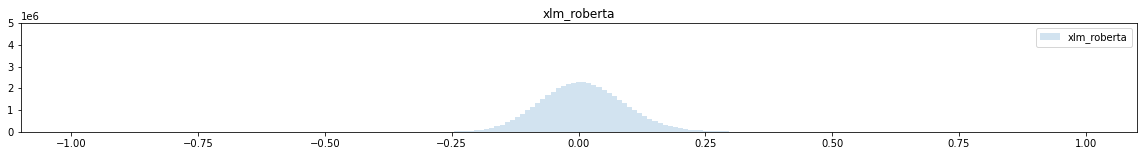

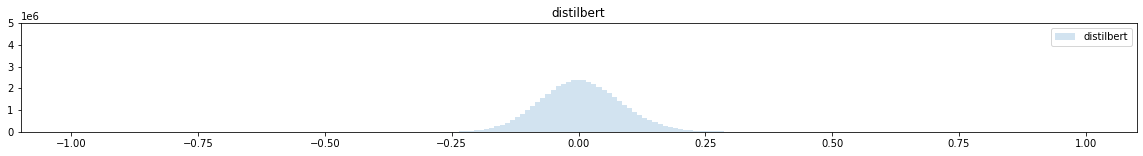

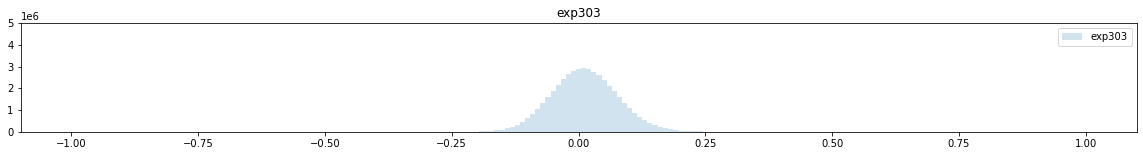

In [120]:

for model_name in model_dist_dict.keys():
    plt.figure(figsize=(20, 2))
    if model_name == "exp303":
        plt.hist(model_dist_dict[model_name]["cosine_similarity"].flatten()*0.52/0.42, alpha=0.2, bins=199, range=(-1, 1), label=model_name)
    else:
        plt.hist(model_dist_dict[model_name]["cosine_similarity"].flatten(), alpha=0.2, bins=199, range=(-1, 1), label=model_name)
    plt.legend()
    plt.ylim(0, 5e+6)
    plt.title(model_name)
    plt.show()